In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import math
import pytz

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## RNN:
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, AdamW, Adamax,SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM, GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout # Careful
from keras.layers import BatchNormalization

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
data_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Electric Vehicle/Electric_Vehicle_Charging_Station_Energy_Consumption_Smooth.csv', delimiter=",")
data_main.reindex(np.arange(len(data_main)))
data_main.reset_index(drop=True)

,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,Port_Type,ObjectId
0,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018/01/20 07:29:00+00,MDT,2018/01/20 09:22:00+00,MDT,1:52:59,1:52:41,4.61,1.94,0.58,Level 2,1
1,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018/01/20 11:42:00+00,MDT,2018/01/20 15:27:00+00,MDT,3:45:39,2:22:15,4.61,2.81,0.84,Level 2,2
2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018/01/20 11:51:00+00,MDT,2018/01/20 12:54:00+00,MDT,1:03:01,1:02:50,4.61,2.88,0.86,Level 2,3
3,BOULDER / REC CENTER ST1,1360 Gillaspie Dr,Boulder,Colorado,80305,2018/01/20 14:54:00+00,MDT,2018/01/20 15:52:00+00,MDT,0:58:33,0:58:25,3.98,1.67,0.50,Level 2,5
4,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018/01/20 20:21:00+00,MDT,2018/01/21 08:06:00+00,MDT,11:44:35,3:09:24,5.88,2.47,0.74,Level 2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39807,BOULDER / CARPENTER PARK1,1505 30th St,Boulder,Colorado,80303,2022/07/31 18:51:00+00,MDT,2022/07/31 21:31:00+00,MDT,2:39:58,2:39:29,6.05,4.30,0.76,Level 2,43655
39808,COMM VITALITY / 1100WALNUT1,1100 Walnut,Boulder,Colorado,80302,2022/07/31 19:08:00+00,MDT,2022/07/31 20:14:00+00,MDT,1:06:27,1:06:03,4.49,3.19,0.56,Level 2,43656
39809,COMM VITALITY / 1100WALNUT1,1100 Walnut,Boulder,Colorado,80302,2022/07/31 19:25:00+00,MDT,2022/07/31 20:38:00+00,MDT,1:12:50,1:10:41,6.86,4.87,0.86,Level 2,43657
39810,BOULDER / CARPENTER PARK2,1505 30th St,Boulder,Colorado,80303,2022/07/31 21:44:00+00,MDT,2022/07/31 23:49:00+00,MDT,2:04:26,2:04:10,9.48,6.73,1.19,Level 2,43658


In [5]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39812 entries, 0 to 39811
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station_Name                39812 non-null  object 
 1   Address                     39812 non-null  object 
 2   City                        39812 non-null  object 
 3   State_Province              39812 non-null  object 
 4   Zip_Postal_Code             39812 non-null  int64  
 5   Start_Date___Time           39812 non-null  object 
 6   Start_Time_Zone             39812 non-null  object 
 7   End_Date___Time             39812 non-null  object 
 8   End_Time_Zone               39812 non-null  object 
 9   Total_Duration__hh_mm_ss_   39812 non-null  object 
 10  Charging_Time__hh_mm_ss_    39812 non-null  object 
 11  Energy__kWh_                39812 non-null  float64
 12  GHG_Savings__kg_            39812 non-null  float64
 13  Gasoline_Savings__gallons_  398

<ipython-input-6-8b948964c71a>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  a = sns.heatmap(data_main.corr(), annot=True, fmt=".2f", annot_kws={"size": 10});


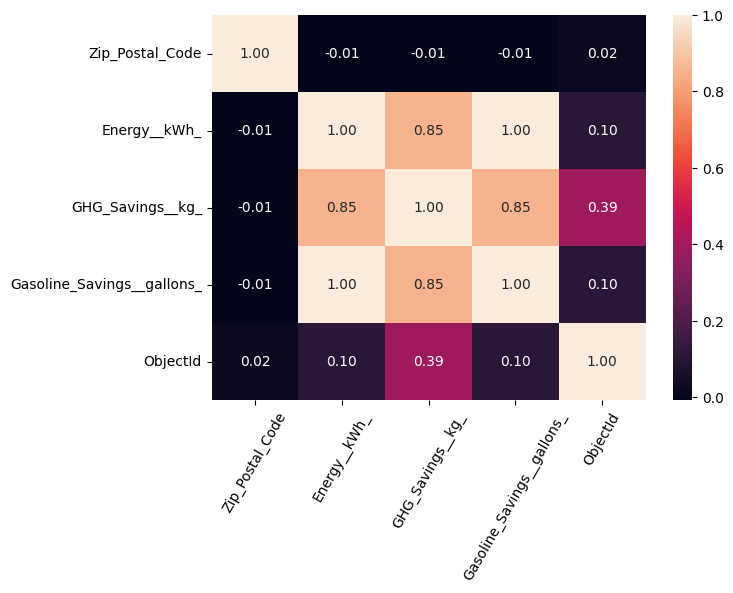

In [6]:
#Correlation Map
import seaborn as sns
plt.figure(figsize=(7,5));
a = sns.heatmap(data_main.corr(), annot=True, fmt=".2f", annot_kws={"size": 10});
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=60)
plt.show();

In [7]:
data_main = data_main.drop(['Station_Name','Address','City','State_Province','Start_Time_Zone','End_Date___Time','End_Time_Zone','Total_Duration__hh_mm_ss_','Charging_Time__hh_mm_ss_','Port_Type','ObjectId','Zip_Postal_Code'], axis=1)


In [8]:
data_main

,Start_Date___Time,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_
0,2018/01/20 07:29:00+00,4.61,1.94,0.58
1,2018/01/20 11:42:00+00,4.61,2.81,0.84
2,2018/01/20 11:51:00+00,4.61,2.88,0.86
3,2018/01/20 14:54:00+00,3.98,1.67,0.50
4,2018/01/20 20:21:00+00,5.88,2.47,0.74
...,...,...,...,...
39807,2022/07/31 18:51:00+00,6.05,4.30,0.76
39808,2022/07/31 19:08:00+00,4.49,3.19,0.56
39809,2022/07/31 19:25:00+00,6.86,4.87,0.86
39810,2022/07/31 21:44:00+00,9.48,6.73,1.19


In [9]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39812 entries, 0 to 39811
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Start_Date___Time           39812 non-null  object 
 1   Energy__kWh_                39812 non-null  float64
 2   GHG_Savings__kg_            39812 non-null  float64
 3   Gasoline_Savings__gallons_  39812 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.2+ MB


In [10]:
data_main = data_main
data_main["DateTime"] = pd.to_datetime(data_main["Start_Date___Time"])
data_main.set_index("DateTime", drop=True, inplace=True)
data_main = data_main.drop(['Start_Date___Time'], axis=1)
data_main.sort_index(inplace=True)
data_main.to_csv('/content/drive/MyDrive/Colab Notebooks/Electric Vehicle/Electric_Data.csv')


In [11]:
data_main

,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_
DateTime,,,
2018-01-01 17:49:00+00:00,7.69,3.23,0.96
2018-01-02 08:52:00+00:00,4.49,1.89,0.56
2018-01-02 21:11:00+00:00,8.76,3.68,1.10
2018-01-03 09:19:00+00:00,11.00,4.62,1.38
2018-01-03 14:13:00+00:00,4.37,1.84,0.55
...,...,...,...
2022-07-31 18:51:00+00:00,6.05,4.30,0.76
2022-07-31 19:08:00+00:00,4.49,3.19,0.56
2022-07-31 19:25:00+00:00,6.86,4.87,0.86


In [12]:
df2=data_main.resample('360min').agg({"Energy__kWh_":"sum","GHG_Savings__kg_":"sum","Gasoline_Savings__gallons_":"sum"})

In [13]:
for x in ['Energy__kWh_','GHG_Savings__kg_','Gasoline_Savings__gallons_']:
    q75,q25 = np.percentile(df2.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df2.loc[df2[x] < min,x] = np.nan
    df2.loc[df2[x] > max,x] = np.nan

In [14]:
df2.isnull().sum()

Energy__kWh_                  198
GHG_Savings__kg_              473
Gasoline_Savings__gallons_    198
dtype: int64

In [15]:
df2

,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_
DateTime,,,
2018-01-01 12:00:00+00:00,7.69,3.23,0.96
2018-01-01 18:00:00+00:00,0.00,0.00,0.00
2018-01-02 00:00:00+00:00,0.00,0.00,0.00
2018-01-02 06:00:00+00:00,4.49,1.89,0.56
2018-01-02 12:00:00+00:00,0.00,0.00,0.00
...,...,...,...
2022-07-30 18:00:00+00:00,91.54,65.00,11.49
2022-07-31 00:00:00+00:00,12.34,8.76,1.55
2022-07-31 06:00:00+00:00,151.92,NaN,19.07


In [16]:
df2.fillna(df2.dtypes.replace({'float64': 0.000, 'O': 'NULL'}), inplace=True)
df2.replace(0, np.nan, inplace=True)

In [17]:
df2.dropna(subset=['Energy__kWh_','GHG_Savings__kg_','Gasoline_Savings__gallons_'], inplace = True)


In [18]:
df2

,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_
DateTime,,,
2018-01-01 12:00:00+00:00,7.69,3.23,0.96
2018-01-02 06:00:00+00:00,4.49,1.89,0.56
2018-01-02 18:00:00+00:00,8.76,3.68,1.10
2018-01-03 06:00:00+00:00,11.00,4.62,1.38
2018-01-03 12:00:00+00:00,6.51,2.74,0.82
...,...,...,...
2022-07-29 18:00:00+00:00,70.08,49.76,8.81
2022-07-30 00:00:00+00:00,5.40,3.83,0.68
2022-07-30 18:00:00+00:00,91.54,65.00,11.49


In [19]:
df2["EV_lag_1"] = df2["Energy__kWh_"].shift(-1)
df2["EV_lag_2"] = df2["Energy__kWh_"].shift(-2)
df2["EV_lag_3"] = df2["Energy__kWh_"].shift(-3)
#df2["EV_lag_4"] = df2["Energy__kWh_"].shift(-4)
#df2["EV_lag_5"] = df2["Energy__kWh_"].shift(-5)
#df2["EV_lag_6"] = df2["Energy__kWh_"].shift(-6)

In [20]:
df2=df2.reset_index()

In [21]:
# We have every 4hours of data ready now
df3=df2.filter(['Energy__kWh_','GHG_Savings__kg_','Gasoline_Savings__gallons_','EV_lag_1','EV_lag_2','EV_lag_3'], axis=1)
df3

,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,EV_lag_1,EV_lag_2,EV_lag_3
0,7.69,3.23,0.96,4.49,8.76,11.00
1,4.49,1.89,0.56,8.76,11.00,6.51
2,8.76,3.68,1.10,11.00,6.51,3.46
3,11.00,4.62,1.38,6.51,3.46,25.90
4,6.51,2.74,0.82,3.46,25.90,19.89
...,...,...,...,...,...,...
4695,70.08,49.76,8.81,5.40,91.54,12.34
4696,5.40,3.83,0.68,91.54,12.34,54.10
4697,91.54,65.00,11.49,12.34,54.10,NaN
4698,12.34,8.76,1.55,54.10,NaN,NaN


In [22]:
missing_col = ['Energy__kWh_','GHG_Savings__kg_','Gasoline_Savings__gallons_','EV_lag_1','EV_lag_2','EV_lag_3']
#Technique 1: Using mean to impute the missing values
for i in missing_col:
 df3.loc[df3.loc[:,i].isnull(),i]=df3.loc[:,i].mean()

In [23]:
df3

,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,EV_lag_1,EV_lag_2,EV_lag_3
0,7.69,3.23,0.96,4.490000,8.760000,11.000000
1,4.49,1.89,0.56,8.760000,11.000000,6.510000
2,8.76,3.68,1.10,11.000000,6.510000,3.460000
3,11.00,4.62,1.38,6.510000,3.460000,25.900000
4,6.51,2.74,0.82,3.460000,25.900000,19.890000
...,...,...,...,...,...,...
4695,70.08,49.76,8.81,5.400000,91.540000,12.340000
4696,5.40,3.83,0.68,91.540000,12.340000,54.100000
4697,91.54,65.00,11.49,12.340000,54.100000,53.329793
4698,12.34,8.76,1.55,54.100000,53.320307,53.329793


In [25]:
df3.drop(df3.tail(20).index,inplace = True)

In [26]:
#df3 is our final dataset we need to use to predict the next days first 1440 hours of charging
df3


,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,EV_lag_1,EV_lag_2,EV_lag_3
0,7.69,3.23,0.96,4.49,8.76,11.00
1,4.49,1.89,0.56,8.76,11.00,6.51
2,8.76,3.68,1.10,11.00,6.51,3.46
3,11.00,4.62,1.38,6.51,3.46,25.90
4,6.51,2.74,0.82,3.46,25.90,19.89
...,...,...,...,...,...,...
4675,74.99,53.25,9.41,14.79,100.71,11.04
4676,14.79,10.50,1.86,100.71,11.04,69.86
4677,100.71,71.51,12.65,11.04,69.86,3.50
4678,11.04,7.84,1.38,69.86,3.50,90.78


In [27]:
# Hour 75%
#train=df3[0:32744]
#test=df3[32744:40128]

# 80% Day
train=df3[0:3509]
test=df3[3509:4680]

In [28]:
test.to_csv('/content/drive/MyDrive/Colab Notebooks/Electric Vehicle/Test_Data.csv')

In [29]:
#train_X=train[['Energy__kWh_','GHG_Savings__kg_','EV_lag_1','EV_lag_2','EV_lag_3','EV_lag_4','EV_lag_5']]

In [30]:
#train_X=train[['GHG_Savings__kg_','Gasoline_Savings__gallons_','EV_lag_1','EV_lag_2','EV_lag_3','EV_lag_4','EV_lag_5','EV_lag_6']]

In [31]:
train_X=train[['Energy__kWh_','GHG_Savings__kg_','Gasoline_Savings__gallons_','EV_lag_1','EV_lag_2']]
train_y=train[['EV_lag_3']]
#train_y=train[['Energy__kWh_']]
test_X=test[['Energy__kWh_','GHG_Savings__kg_','Gasoline_Savings__gallons_','EV_lag_1','EV_lag_2']]
test_y=test[['EV_lag_3']]
#test_y=test[['Energy__kWh_']]

In [32]:
#Scaling has to be done for LSTM
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc2= StandardScaler()
train_X_sc=sc.fit_transform(train_X)
train_y_sc=sc2.fit_transform(train_y)
test_X_sc=sc.transform(test_X)
test_y_sc=X_test = sc2.transform(test_y)

In [33]:
train_X_sc = pd.DataFrame(train_X_sc)
train_y_sc = pd.DataFrame(train_y_sc)
test_X_sc = pd.DataFrame(test_X_sc)
test_y_sc = pd.DataFrame(test_y_sc)



In [ ]:
# create and fit the LSTM network 1
model = Sequential()
model.add(LSTM(8, input_shape=(5,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(train_X_sc, train_y_sc, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
3509/3509 - 10s - loss: 0.9063 - 10s/epoch - 3ms/step
Epoch 2/100
3509/3509 - 9s - loss: 0.8846 - 9s/epoch - 3ms/step
Epoch 3/100
3509/3509 - 11s - loss: 0.8611 - 11s/epoch - 3ms/step
Epoch 4/100
3509/3509 - 8s - loss: 0.8431 - 8s/epoch - 2ms/step
Epoch 5/100
3509/3509 - 9s - loss: 0.8321 - 9s/epoch - 3ms/step
Epoch 6/100
3509/3509 - 9s - loss: 0.8264 - 9s/epoch - 3ms/step
Epoch 7/100
3509/3509 - 8s - loss: 0.8244 - 8s/epoch - 2ms/step
Epoch 8/100
3509/3509 - 10s - loss: 0.8186 - 10s/epoch - 3ms/step
Epoch 9/100
3509/3509 - 9s - loss: 0.8177 - 9s/epoch - 3ms/step
Epoch 10/100
3509/3509 - 9s - loss: 0.8167 - 9s/epoch - 2ms/step
Epoch 11/100
3509/3509 - 9s - loss: 0.8150 - 9s/epoch - 3ms/step
Epoch 12/100
3509/3509 - 8s - loss: 0.8126 - 8s/epoch - 2ms/step
Epoch 13/100
3509/3509 - 9s - loss: 0.8124 - 9s/epoch - 3ms/step
Epoch 14/100
3509/3509 - 9s - loss: 0.8127 - 9s/epoch - 3ms/step
Epoch 15/100
3509/3509 - 8s - loss: 0.8093 - 8s/epoch - 2ms/step
Epoch 16/100
3509/3509 - 9s 

In [ ]:
# make predictions
trainPredict = pd.DataFrame(model.predict(train_X_sc))
testPredict = pd.DataFrame(model.predict(test_X_sc))

37/37 [==============================] - 0s 3ms/step


In [ ]:
# invert predictions
trainPredict = sc2.inverse_transform(trainPredict)
testPredict = sc2.inverse_transform(testPredict)

In [ ]:
trainPredict = pd.DataFrame(trainPredict)
testPredict = pd.DataFrame(testPredict)

In [ ]:
#invert train y and test y
train_y_plot = pd.DataFrame(sc2.inverse_transform(train_y_sc))
test_y_plot = pd.DataFrame(sc2.inverse_transform(test_y_sc))

In [ ]:
trainScore = math.sqrt(mean_squared_error(train_y_plot, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y_plot, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 33.53 RMSE
Test Score: 43.22 RMSE


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
r2_score(train_y_plot, trainPredict)

0.22845592817534677

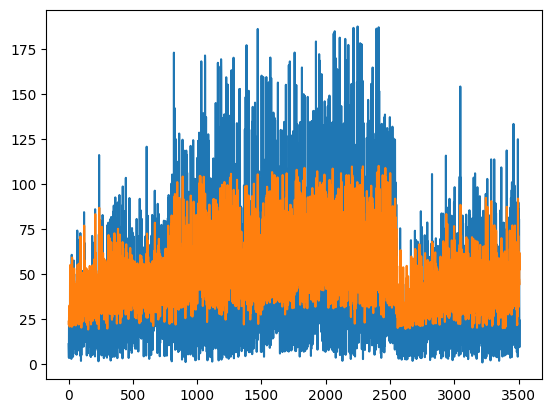

In [ ]:
# plot baseline and predictions
plt.plot(train_y_plot)
plt.plot(trainPredict)
plt.show()

In [ ]:
train_y_plot.to_csv('/content/drive/MyDrive/Colab Notebooks/Electric Vehicle/Trainy.csv')
trainPredict.to_csv('/content/drive/MyDrive/Colab Notebooks/Electric Vehicle/TrainPredict.csv')

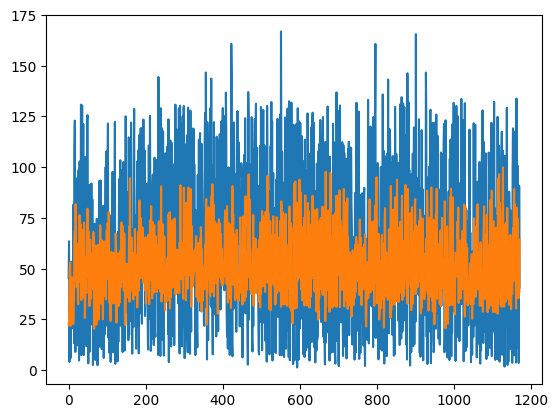

In [ ]:
plt.plot(test_y_plot)
plt.plot(testPredict)
plt.show()

In [ ]:
test_y_plot.to_csv('/content/drive/MyDrive/Colab Notebooks/Electric Vehicle/Testy.csv')
testPredict.to_csv('/content/drive/MyDrive/Colab Notebooks/Electric Vehicle/TestPredict.csv')

In [ ]:
from numpy import savetxt
# save to csv file
savetxt('features.csv', trainPredict, delimiter=',')
savetxt('features2.csv', train_y_plot, delimiter=',')

In [ ]:
# MAPE function
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def median_ape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.median(np.abs((actual - pred) / actual)) * 100

In [ ]:
# Calculate MAPE
mape_train = mape(train_y_plot+0.01, trainPredict)
mape_test = mape(test_y_plot+0.01, testPredict)
print("MAPE of training set:",np.round(mape_train,2), "MAPE of testing set:", np.round(mape_test,2))



MAPE of training set: 140.65 MAPE of testing set: 155.59


In [ ]:
# create and fit the LSTM network 2
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(5,1)))
model.add(LSTM(16))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1))
optimizer = Adam(clipvalue=2.0)
model.compile(loss='mean_squared_error', optimizer=optimizer)
#model.compile(loss='mean_absolute_error', optimizer=optimizer)

model.fit(train_X_sc, train_y_sc, epochs=100, batch_size=8, verbose=2)

Epoch 1/100
439/439 - 7s - loss: 1.0367 - 7s/epoch - 16ms/step
Epoch 2/100
439/439 - 3s - loss: 0.9298 - 3s/epoch - 8ms/step
Epoch 3/100
439/439 - 4s - loss: 0.8874 - 4s/epoch - 9ms/step
Epoch 4/100
439/439 - 3s - loss: 0.8718 - 3s/epoch - 7ms/step
Epoch 5/100
439/439 - 3s - loss: 0.8672 - 3s/epoch - 7ms/step
Epoch 6/100
439/439 - 3s - loss: 0.8623 - 3s/epoch - 7ms/step
Epoch 7/100
439/439 - 4s - loss: 0.8666 - 4s/epoch - 10ms/step
Epoch 8/100
439/439 - 3s - loss: 0.8604 - 3s/epoch - 7ms/step
Epoch 9/100
439/439 - 3s - loss: 0.8550 - 3s/epoch - 7ms/step
Epoch 10/100
439/439 - 3s - loss: 0.8553 - 3s/epoch - 7ms/step
Epoch 11/100
439/439 - 4s - loss: 0.8564 - 4s/epoch - 10ms/step
Epoch 12/100
439/439 - 3s - loss: 0.8535 - 3s/epoch - 7ms/step
Epoch 13/100
439/439 - 3s - loss: 0.8519 - 3s/epoch - 7ms/step
Epoch 14/100
439/439 - 3s - loss: 0.8527 - 3s/epoch - 7ms/step
Epoch 15/100
439/439 - 4s - loss: 0.8536 - 4s/epoch - 9ms/step
Epoch 16/100
439/439 - 3s - loss: 0.8528 - 3s/epoch - 8ms/ste

In [ ]:
trainPredict = pd.DataFrame(model.predict(train_X_sc))
testPredict = pd.DataFrame(model.predict(test_X_sc))

37/37 [==============================] - 0s 3ms/step


In [ ]:
# invert predictions
trainPredict = sc2.inverse_transform(trainPredict)
testPredict = sc2.inverse_transform(testPredict)

In [ ]:
trainPredict = pd.DataFrame(trainPredict)
testPredict = pd.DataFrame(testPredict)

In [ ]:
#invert train y and test y
train_y_plot = pd.DataFrame(sc2.inverse_transform(train_y_sc))
test_y_plot = pd.DataFrame(sc2.inverse_transform(test_y_sc))

In [ ]:
testPredict=abs(testPredict)

In [ ]:
trainScore = math.sqrt(mean_squared_error(train_y_plot, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y_plot, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 33.99 RMSE
Test Score: 42.07 RMSE


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
r2_score(train_y_plot, trainPredict)

0.20755825936749683

In [ ]:
mean_absolute_error(train_y_plot, trainPredict)

In [ ]:
trainPredict=abs(trainPredict)

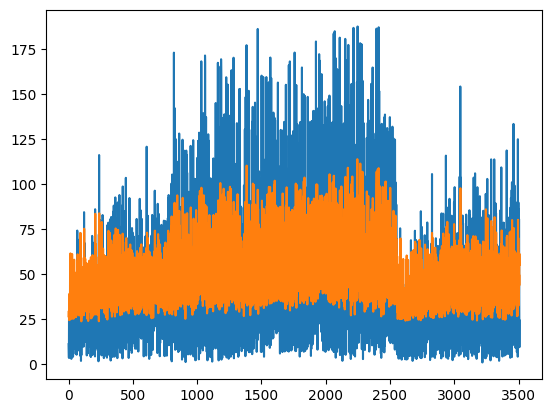

In [ ]:
# plot baseline and predictions
plt.plot(train_y_plot)
plt.plot(trainPredict)
plt.show()

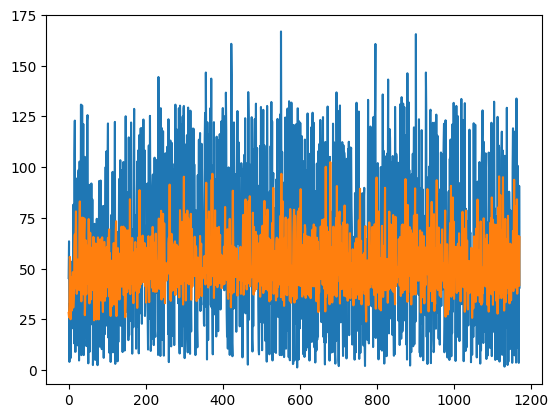

In [ ]:
# plot baseline and predictions
plt.plot(test_y_plot)
plt.plot(testPredict)
plt.show()

In [ ]:
# Calculate MAPE
mape_train = mape(train_y_plot+0.01, trainPredict)
mape_test = mape(test_y_plot+0.01, testPredict)
print("MAPE of training set:",np.round(mape_train,2), "MAPE of testing set:", np.round(mape_test,2))


MAPE of training set: 127.14 MAPE of testing set: 172.98


In [ ]:
test_y_plot.to_csv('/content/drive/MyDrive/Colab Notebooks/Electric Vehicle/test_y_plot.csv')
testPredict.to_csv('/content/drive/MyDrive/Colab Notebooks/Electric Vehicle/testPredict.csv')

GRU

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model1 = keras.Sequential()
model1.add(layers.GRU(64, input_shape=(1, 6)))
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(10))
print(model1.summary())


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                13824     
                                                                 
 batch_normalization_18 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 10)                650       
                                                                 
Total params: 14,730
Trainable params: 14,602
Non-trainable params: 128
_________________________________________________________________
None


In [ ]:
model1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)

In [ ]:
model.fit(
    train_X_sc, train_y_sc, validation_data=(test_X_sc, test_y_sc), batch_size=4, epochs=100)


Epoch 1/100
857/857 [==============================] - 13s 16ms/step - loss: 0.4203 - val_loss: 0.8063
Epoch 2/100
857/857 [==============================] - 13s 15ms/step - loss: 0.3933 - val_loss: 0.8850
Epoch 3/100
857/857 [==============================] - 10s 12ms/step - loss: 0.4398 - val_loss: 1.0001
Epoch 4/100
857/857 [==============================] - 9s 11ms/step - loss: 0.4295 - val_loss: 0.8009
Epoch 5/100
857/857 [==============================] - 9s 11ms/step - loss: 0.4089 - val_loss: 0.8817
Epoch 6/100
857/857 [==============================] - 10s 12ms/step - loss: 0.4299 - val_loss: 0.9231
Epoch 7/100
857/857 [==============================] - 10s 12ms/step - loss: 0.4300 - val_loss: 1.0032
Epoch 8/100
857/857 [==============================] - 9s 11ms/step - loss: 0.4138 - val_loss: 0.8783
Epoch 9/100
857/857 [==============================] - 11s 13ms/step - loss: 0.4325 - val_loss: 1.0287
Epoch 10/100
857/857 [==============================] - 15s 17ms/step - loss

In [ ]:
trainPredict = pd.DataFrame(model1.predict(train_X_sc))
testPredict = pd.DataFrame(model1.predict(test_X_sc))

ValueError: ignored

In [ ]:
#for i in range(10):
#    result = tf.argmax(model1.predict(tf.expand_dims(test_X_sc[i], 0)), axis=1)
#    print(result.numpy(), test_y_sc[i])


In [ ]:
trainPredict = sc2.inverse_transform(trainPredict)
testPredict = sc2.inverse_transform(testPredict)

In [ ]:
trainPredict = pd.DataFrame(trainPredict)
testPredict = pd.DataFrame(testPredict)

In [ ]:
train_y_plot = pd.DataFrame(sc2.inverse_transform(train_y_sc))
test_y_plot = pd.DataFrame(sc2.inverse_transform(test_y_sc))

In [ ]:
testPredict=abs(testPredict)

In [ ]:
trainScore = math.sqrt(mean_squared_error(train_y_plot, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y_plot, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# plot baseline and predictions
plt.plot(train_y_plot)
plt.plot(trainPredict)
plt.show()

In [ ]:
# plot baseline and predictions
plt.plot(test_y_plot)
plt.plot(testPredict)
plt.show()